## Libraries

In [1]:
import numpy as np
from pulp import *

import copy
import math
import time
import datetime
from input_data import instance_name, speed, t_max, display_results
from input_data import processing_time_limit, solver
from input_data import nodesize, nodecolor, nodeboundary, team_color, open_road_color,closed_road_color
from read_instance_file import retrieve_file_data
from MPC_ARCP_visualization import get_f_values, organize_teams_routes, save_RC_variables, data_visualization

# 1) Input data processing

In [2]:
def create_traversing_time_matrix(n, coordinates, list_of_edges,speed):
    """This function creates a matrix with the euclidean distance of each pair of vertices"""
    #Create an empty traversing matrix 
    traversing_time = np.array([[np.inf for i in range(n+1)] for i in range(n+1)])
    
    #Calculate the euclidean distance for each pair of nodes
    for edge in list_of_edges:
        #Define the nodes
        n1 = edge[0]
        n2 = edge[1]
        #Identify the coordinates of node 1 (n1)
        x1 = coordinates[n1][0]
        y1 = coordinates[n1][1]
        #Identify the coordinates of node 2 (n2)
        x2 = coordinates[n2][0]
        y2 = coordinates[n2][1]
        #Calculate the Euclidean distance
        d = round(math.sqrt(((x2-x1)**2 + (y2-y1)**2))/speed,2)
        traversing_time[n1,n2] = d
    
    #Update the last column of the traversing_time to allow going to the sink node
    for i in range(n):
        traversing_time[i, n] = 0
    return traversing_time   

In [3]:
def unblocking_time_matrix(n, damaged_edges):
    """This function converts the information of the blocked edges into matrix form"""
    #Create an empty unblocking time matrix 
    unblocking_time = np.array([[float(0) for i in range(n+1)] for i in range(n+1)])
    
    #Update the unblocking time for each damaged edge
    for edge in damaged_edges:
        #Define the nodes
        n1 = edge[0]
        n2 = edge[1]
        #Retrieve the unblocking time
        unblocking_time[n1, n2] = edge[2]
    return unblocking_time

In [4]:
def relative_prizes_matrix(relative_prizes, components):
    """This function converts the information of the components prizes into matrix form"""
    #Create an empty matrix
    pqq = np.array([[0 for _ in range(len(components))] for _ in range(len(components))])
    
    #Update the matrix with the relative prizes
    for prize in relative_prizes:
        i = prize[0]
        j = prize[1]
        pqq[i,j] = prize[2]  
    return pqq

# 3) Mixed Integer Programming Model

In [5]:
#Initialize LP
MPC_ARCP = LpProblem("MPC-ARCP", LpMaximize)

#Retrieve data from the instance file
nodes, all_depots, coordinates, list_of_edges, damaged_edges, relative_prizes, teams_depot, components = retrieve_file_data(instance_name)

## 3.1) Sets and parameters

In [6]:
#Create list of every team's depot
D = []
for i in range(len(teams_depot)):
    depot = teams_depot[i][0]
    for j in range(teams_depot[i][1]):
        D.append(depot)

#Number of teams
nb_teams = len(D)

#n = number of nodes (sink + communities/roads) (0...n-1)
n = copy.deepcopy(nodes)

#sink node
sink = copy.deepcopy(n)

#Traversing times
cij = create_traversing_time_matrix(n, coordinates, list_of_edges, speed)

#Unblocking times
bij = unblocking_time_matrix(n, damaged_edges)

#Pqq = Relative Prizes of components
Pqq = relative_prizes_matrix(relative_prizes, components)

#Set of components
Q = [i for i in range(len(components))]

#QQ = Combination of components
QQ = [(i,j) for i in range(len(components)) for j in range(len(components))]

#Set of nodes in each component
Vq = components

#Set of available teams
K = [i for i in range(nb_teams)]

#Set of all the edges in the network
E = [(i,j) for i in range(n+1) 
      for j in range(n+1) 
      if cij[i,j] != np.inf]

#Set of all the edges in the network, except the artificial edges connecting the sink vertex
E_no_sink = [(i,j) for i in range(n) 
      for j in range(n) 
      if cij[i,j] != np.inf]


#Set of all the edges (i,j) combined with the teams k
Ek = [(i,j,k) for k in K
      for i in range(n+1) 
      for j in range(n+1) 
      if cij[i,j] != np.inf]

#Combination of two edges in set E: (i,j) with (j,l)
EE = [(i,j,l) for i in range(n+1) 
      for j in range(n+1) 
      for l in range(n+1) 
      if cij[i,j] != np.inf
     if cij[j,l] != np.inf]

#Combination of two edges in set E: (i,j) with (j,l) for every team k
EEk = [(i,j,l,k) for k in K 
      for i in range(n+1) 
      for j in range(n+1) 
      for l in range(n+1) 
      if cij[i,j] != np.inf
     if cij[j,l] != np.inf]

#Set of blocked edges
B = [(i,j) for i in range(n+1) 
      for j in range(n+1) 
      if bij[i,j] != 0]

#Set of blocked edges combined with every team k
Bk = [(i,j, k) for k in K 
     for i in range(n+1) 
      for j in range(n+1) 
      if bij[i,j] != 0]

#Set of vertices
V = [i for i in range(n+1)]

#Set of vertices combined with every team k
Vk = [(i,k) for k in K for i in range(n+1)]

#M_time = big positive number used in the time constraints
M_time = 0
for i in range(len(cij)):
    for j in range(len(cij)):
        if i != j:
            if cij[i,j] != np.inf:
                M_time += cij[i,j]
for i in range(len(bij)):
    for j in range(len(bij)):
        M_time += bij[i,j]

In [7]:
#Start the time performance counter
start_time = time.perf_counter()

## 3.2) Decision Variables

In [8]:
y = LpVariable.dicts("y", QQ, cat="Binary")
x = LpVariable.dicts("x", EEk, cat="Binary")
z = LpVariable.dicts("z", Bk, cat="Binary")
v = LpVariable.dicts("v", Vk, lowBound=0, cat="Integer")
f = LpVariable.dicts("f", Ek, lowBound=0, cat="Integer")
t = LpVariable.dicts("t", EEk, lowBound=0, cat="Continuous")
s = LpVariable.dicts("s", Bk, lowBound=0, cat="Continuous")
a = LpVariable.dicts("a", Bk, lowBound=0, cat="Continuous")
w = LpVariable.dicts("w", Bk, cat="Binary")

## 3.3) Objective Function

\begin{equation} \label{eqn} 
    Maximize Z = \frac{1}{2}\sum_{q_{1} \in Q} \sum_{q_{2} \in Q, \\ q_{1}\neq q_{2}} P_{q_{1}q_{2}} * y_{q_{1}q_{2}}
    \end{equation}

In [9]:
MPC_ARCP += 0.5*lpSum(Pqq[q1,q2]*y[q1,q2] for q1 in range(len(components)) for q2 in range(len(components)) if q2 != q1)

## 3.4) Constraints

\begin{equation}
	y_{q1q2} \leq \sum_{(i,j) \in B, \\ i \in V_{q_{1}}, \\ j \in V_{q_{2}}, \\ k \in K} z_{ijk} + z_{jik}, \forall q_{1} \in Q, q_{2} \in Q, q_{1} \neq q_{2}
	\end{equation}

In [10]:
for q1 in Q:
    for q2 in Q:
        if q1 != q2:
            MPC_ARCP += y[q1,q2] <= lpSum([z[i,j,k] + z[j,i,k] 
                                       for (i,j) in B if i in Vq[q1] and j in Vq[q2] 
                                       for k in K])

### 3.4.1) Flow balance constraints

#### 3.4.1.1) Flow at the depot

\begin{equation}
    \sum_{(d_{k},j) \in E} \sum_{(j,l) \in E} x_{d_{k}jlk} = 1, \forall k \in K
	\end{equation}

In [11]:
for k in K:
    MPC_ARCP += lpSum([x[i,j,l,k] for (i,j,l) in EE if i == D[k]]) == 1

#### 3.4.1.2) Flow at the sink vertex
\begin{equation}
    \sum_{(i,j) \in E,\\ j \neq n+1} \sum_{(j,n+1) \in E} x_{ij(n+1)k} = 1, \forall k \in K
	\end{equation}

In [12]:
for k in K:
    MPC_ARCP += lpSum([x[i,j,l,k] for (i,j,l) in EE if l == sink and j != sink]) == 1

#### 3.4.1.3) Flow at the other nodes
\begin{equation}
    x_{ijlk} \leq \sum_{(l,h) \in E} x_{jlhk}, \forall (i,j) \in E, i\neq d_{k}, (j,l) \in E, l\neq n+1, k \in K
	\end{equation}

In [13]:
for k in K:
    for (i,j,l) in EE:
        if i != D[k]:
            if l != sink:
                MPC_ARCP += x[i,j,l,k] <= lpSum([x[j,l,h,k] for (w,m,h) in EE if w == j and m == l])

\begin{equation}
    x_{jlhk} \leq \sum_{(i,j) \in E} x_{ijlk}, \forall (j,l) \in E, j\neq d_{k}, (l,h) \in E, k \in K
	\end{equation}

In [14]:
for k in K:
    for (j,l,h) in EE:
        if j != D[k]:
            MPC_ARCP += x[j,l,h,k] <= lpSum([x[i,j,l,k] for (i,w,m) in EE if w == j and m == l])

\begin{equation}
    \sum_{(j,l) \in E} x_{ijlk} \leq 1, \forall (i,j) \in E, j \neq n+1, k \in K
	\end{equation}

In [15]:
for k in K:
    for (i,j) in E:
        if j != sink:
            MPC_ARCP += lpSum([x[i,j,l,k] for (w,m,l) in EE if w == i and m == j]) <= 1

\begin{equation}
    \sum_{(i,j) \in E} x_{ijlk} \leq 1, \forall (j,l) \in E, k \in K
	\end{equation}

In [16]:
for k in K:
    for (j,l) in E:
        MPC_ARCP += lpSum([x[i,j,l,k] for (i,w,m) in EE if w == j and m == l]) <= 1

### 3.4.2) Unblocking coordination constraints

\begin{equation}
    \sum_{(j,l) \in E} x_{ijlk} \geq z_{ijk}, \forall (i,j) \in B, k \in K
	\end{equation}

In [17]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += lpSum([x[i,j,l,k] for (w,m,l) in EE if w == i and m == j]) >= z[i,j,k]

\begin{equation}
    \sum_{(j,l) \in E} x_{ijlk} + \sum_{(i,l) \in E} x_{jilk} \geq 2(\sum_{\alpha \in K} z_{ij\alpha} +  \sum_{\alpha \in K} z_{ji\alpha}), \forall (i,j) \in B, k \in K
	\end{equation}

In [18]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += lpSum([x[i,j,l,k] for (w,m,l) in EE if w == i if m == j]) + lpSum([x[j,i,l,k] for (w,m,l) in EE if w == j if m == i]) <= 2*(lpSum([z[i,j,alpha] for (w,m,alpha) in Bk if w == i if m == j]) + lpSum([z[j,i,alpha] for (w,m,alpha) in Bk if w == j if m == i]))

\begin{equation}
    \sum_{k \in K} z_{ijk} + \sum_{k \in K} z_{jik} \leq 2, \forall (i,j) \in B
	\end{equation}

In [19]:
for (i,j) in B:
    MPC_ARCP += lpSum([z[i,j,k] for k in K]) + lpSum([z[j,i,k] for k in K]) <= 2

\begin{equation}
    z_{ijk} + z_{jik} \leq 1, \forall (i,j) \in B, k \in K
	\end{equation}

In [20]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += z[i,j,k] + z[j,i,k] <= 1

### 3.4.3) Subtour elimination constraints

\begin{equation}
    \sum_{(j,i) \in E} \sum_{(i,l) \in E} x_{jilk} = v_{ik}, \forall k \in K, i \in V \setminus \{d_{k}, n+1\}
	\end{equation}

In [21]:
for k in K:
    for i in V:
        if i != D[k]:
            if i != sink:
                MPC_ARCP += lpSum([x[j,i,l,k] for (j,w,l) in EE if w==i])== v[i, k]

\begin{equation}
    \sum_{(i,j) \in E} \sum_{(j, n+1) \in E} x_{ij(n+1)k} = v_{(n+1)k}, \forall k \in K
	\end{equation}

In [22]:
for k in K:
    MPC_ARCP += lpSum([x[i,j,sink,k] for (i,j,l) in EE if l==sink]) == v[sink, k]

\begin{equation}
    \sum_{(d_{k},j) \in E} f_{d_{k}jk} - \sum_{(j, d_{k}) \in E} f_{jd_{k}k} = \sum_{i \in V \\ i \neq d_{k}} v_{ik} ,\forall k \in K
	\end{equation}

In [23]:
for k in K:
    dk = D[k]
    MPC_ARCP += lpSum([f[dk,j,k] for (w,j) in E if w==dk]) - lpSum([f[j,dk,k] for (j, w) in E if w==dk]) == lpSum([v[i,k] for i in V if i != dk])

\begin{equation}
    \sum_{(j, n+1) \in E} f_{j(n+1)k} = 1,\forall k \in K
	\end{equation}

In [24]:
for k in K:
    MPC_ARCP += lpSum([f[j,sink,k] for (j,w) in E if w==sink]) == 1

\begin{equation}
    f_{ijk} \leq 2*(E)(\sum_{(j,l) \in E} x_{ijlk} ),\forall k \in K, (i,j) \in E, j\neq n+1
	\end{equation}

In [25]:
for k in K:
    for (i,j) in E:
        if j != sink:
            MPC_ARCP += f[i,j,k] <= (2*len(E))*lpSum([x[i,j,l,k] for (w,m,l) in EE if w==i and m==j])

\begin{equation}
    f_{i(n+1)k} \leq 2*(E)(\sum_{(l,i) \in E} x_{li(n+1)k} ),\forall k \in K, (i,n+1) \in E
	\end{equation}

In [26]:
for k in K:
    for (i,j) in E:
        if j == sink:
            MPC_ARCP += f[i,j,k] <= (2*len(E))*lpSum([x[l,i,j,k] for (l,w,m) in EE if w==i and m==j])

\begin{equation}
    f_{ijk} - 1 \geq f_{jlk} - 2*(E)(1- x_{ijlk}), \forall k \in K, (i,j) \in E, (j,l) \in E, j\neq n+1
	\end{equation}

In [27]:
for k in K:
    for (i,j,l) in EE:
        if i != sink:
            if j != sink:
                MPC_ARCP += f[i,j,k] - 1 >= f[j,l,k] - 2*(len(E))*(1-x[i,j,l,k]) 

### 3.4.4) Teams synchronization constraints

\begin{equation}
    t_{ijlk} \leq t_{max}(x_{ijlk}), \forall k \in K, (i,j) \in E, (j,l) \in E, j\neq n+1
	\end{equation}

In [28]:
for k in K:
    for (i,j,l) in EE:
        MPC_ARCP += t[i,j,l,k] <= t_max*x[i,j,l,k]

\begin{equation} 
    \sum_{(j,l) \in E} t_{ijlk} \geq \sum_{(h,i) \in E} t_{hijk} + c_{ij}(\sum_{(j,l) \in E} x_{ijlk}), \forall k \in K, (i,j) \in E \setminus B, j\neq n+1
	\end{equation}

In [29]:
for k in K:
    for (i,j) in E:
        if (i,j) not in B:
            if j != sink:
                MPC_ARCP += lpSum([t[i,j,l,k] for (w,m,l) in EE if w==i and m==j]) >= lpSum([t[h,i,j,k] for (h,w,m) in EE if w==i and m==j]) + cij[i,j]*lpSum([x[i,j,l,k] for (w,m,l) in EE if w==i and m==j])

\begin{equation}
    s_{ijk} \geq \sum_{(h,i) \in E} t_{hijk}, \forall k \in K, (i,j) \in B
	\end{equation}

In [30]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += s[i,j,k] >= lpSum([t[h,i,j,k] for (h,o,m) in EE if o==i and m==j])

\begin{equation}
    \sum_{(i,h) \in E} t_{hijk} - s_{ijk} \leq M_{t}(1-z_{ijk}), \forall k \in K, (i,j) \in B
	\end{equation}

In [31]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += lpSum([t[h,i,j,k] for (h,o,m) in EE if o==i and m==j]) -s[i,j,k] <= M_time*(1-z[i,j,k])

\begin{equation}
    - s_{ijk} + \sum_{(i,h) \in E} t_{hij\alpha}  \leq M_{t}(1-z_{ij\alpha}) + 2M_{t}(\sum_{(i,h) \in E} x_{hijk}), \forall k \in K, \alpha \in K, k \neq \alpha, (i,j) \in B
	\end{equation}

In [32]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += -s[i,j,k] + lpSum([t[i,j,l,alpha] for (o,m,l) in EE if o==i and m==j]) <= M_time*(1-z[i,j,alpha]) + 2*M_time*(1-lpSum([x[h,i,j,k] for (h,o,m) in EE if o==i and m==j]))

### 3.4.5) Collaboration between teams constraints

\begin{equation}
    \sum_{(h,i) \in E} t_{hijk} \geq s_{ijk} + a_{ijk} + c_{ij}(\sum_{(j,l) \in E} x_{ijlk}), \forall k \in K, (i,j) \in B
	\end{equation}

In [33]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += lpSum([t[i,j,l,k] for (o,m,l) in EE if o==i and m==j]) >= s[i,j,k] + a[i,j,k] + cij[i,j]*lpSum([x[i,j,l,k] for (o,m,l) in EE if o==i and m==j])

\begin{equation}
    a_{ijk} \leq b_{ij}*z_{ijk}, \forall k \in K, (i,j) \in B
	\end{equation}

In [34]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += a[i,j,k] <= bij[i,j]*z[i,j,k]

\begin{equation}
    a_{ijk} - b_{ij} \geq M_{t}*(-1 + z_{ijk} - \sum_{\alpha \in K,\\ \alpha \neq K} z_{ji\alpha}), \forall k \in K, (i,j) \in B
	\end{equation}

In [35]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += a[i,j,k] - bij[i,j] >= M_time*(-1 + z[i,j,k] - lpSum([z[j,i,alpha] for (w,m) in B if w==j and m==i for alpha in K if alpha != k]))

\begin{equation}
   2a_{ijk} - b_{ij} + \sum_{(h,i) \in E} t_{hijk} - \sum_{(h,j) \in E} t_{hji\alpha} \geq -M_{t}(3 - z_{ijk} - z_{ij\alpha} - w_{ijk}), \forall (i,j) \in B, k \in K, \alpha \in K, k \neq \alpha 
	\end{equation}

In [36]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += 2*a[i,j,k] -bij[i,j] + lpSum([t[h,i,j,k] for (h,w,m) in EE if w==i and m==j]) - lpSum([t[h,j,i,alpha] for (h,w,m) in EE if w==j and m==i]) >= -M_time*(3-z[i,j,k]-z[j,i,alpha]-w[i,j,k])

\begin{equation}
   2a_{ji\alpha} - b_{ij} + \sum_{(h,j) \in E} t_{hji\alpha} - \sum_{(h,i) \in E} t_{hijk} \geq -M_{t}(3 - z_{ijk} - z_{ij\alpha} - w_{ijk}), \forall (i,j) \in B, k \in K, \alpha \in K, k \neq \alpha 
	\end{equation}

In [37]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += 2*a[j,i,alpha] - bij[i,j] + lpSum([t[h,j,i,alpha] for (h,w,m) in EE if w==j and m==i]) - lpSum([t[h,i,j,k] for (h,w,m) in EE if w==i and m==j]) >= -M_time*(3-z[i,j,k]-z[j,i,alpha]-w[i,j,k])

\begin{equation}
   z_{ijk} \geq w_{ijk}, \forall (i,j) \in B, k \in K 
	\end{equation}

In [38]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += z[i,j,k] >= w[i,j,k]

\begin{equation}
    \sum_{(h,i) \in E} t_{hijk} - \sum_{(h,j) \in E} t_{hji\alpha} \geq M_{t}(w_{ji\alpha} - 1) + 2*M_{t}(z_{ijk} + z_{ij\alpha} - 2), \forall (i,j) \in B, k \in K, \alpha \in K, k \neq \alpha 
	\end{equation}

In [39]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += lpSum([t[h,i,j,k] for (h,w,m) in EE if w==i and m==j]) - lpSum([t[h,j,i,alpha] for (h,w,m) in EE if w==j and m==i]) >= M_time*(w[j,i,alpha] - 1) + 2*M_time*(z[i,j,k] + z[j,i,alpha] - 2)

\begin{equation}
    -1 + z_{ijk} + z_{ji\alpha} \leq w_{ijk} + w_{ji\alpha}, \forall (i,j) \in B, k \in K, \alpha \in K, k \neq \alpha 
	\end{equation}

In [40]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += -1 + z[i,j,k] + z[j,i,alpha] <= w[i,j,k] + w[j,i,alpha]

\begin{equation}
    f_{ijk} - f_{jik} -1 \geq M*(z_{ijk}-1), \forall (i,j) \in B, k \in K
	\end{equation}

In [41]:
for k in K:
    for (i,j) in B:
        MPC_ARCP += f[i,j,k] - f[j,i,k] - 1 >= 2*(len(E))*(z[i,j,k]-1)

\begin{equation}
    s_{ji\alpha} - \sum_{(j,l) \in E} t_{ijlk} \geq M*(z_{ijk}-z_{ji\alpha}-1) + 2M_{t}(\sum_{(i,l) \in E} x_{jil\alpha}), \forall k \in K, \alpha \in K, k \neq \alpha, (i,j) \in B
	\end{equation}

In [42]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += s[j,i,alpha] - lpSum([t[i,j,l,k] for (o,m,l) in EE if o==i and m==j]) >= M_time*(z[i,j,k]-z[j,i,alpha]-1) + 2*M_time*(-1 + lpSum([x[j,i,l,alpha] for (m,o,l) in EE if o==i and m==j]))

\begin{equation}
    a_{ijk} + a_{ji\alpha} - b_{ij} \leq -M*(w_{ijk}-1), \forall k \in K, \alpha \in K, k \neq \alpha, (i,j) \in B
	\end{equation}

In [43]:
for k in K:
    for alpha in K:
        if k != alpha:
            for (i,j) in B:
                MPC_ARCP += a[i,j,k] + a[j,i,alpha] - bij[i,j] <= -M_time*(w[i,j,k]-1)

## 3.5) Solver

In [44]:
#Calling the desired solver
if solver == "GUROBI":
    status = LpStatus[MPC_ARCP.solve(GUROBI_CMD(timeLimit = processing_time_limit, keepFiles = True))]
else:
    status = LpStatus[MPC_ARCP.solve(PULP_CBC_CMD(timeLimit = processing_time_limit, keepFiles = True))]

### 3.5.1) Display the results

In [45]:
#Stop time performance counter
end_time = time.perf_counter()

#Print the processing time
print(f"Processing time = {end_time - start_time} seconds")
print("--------")

#Print the status of the problem
print(f"The problem is {status}")

#Print the objective function value
objective_function = pulp.value(MPC_ARCP.objective)
print("Objective Function Value = ", objective_function)
print("--------")

#If the problem is optimal, print the positive decision variables
if status == "Optimal":
    for var in MPC_ARCP.variables():
        if var.varValue > 0:
            print(f"{var.name} = {var.varValue}")

Processing time = 180.5226147 seconds
--------
The problem is Optimal
Objective Function Value =  19.0
--------
a_(2,_3,_0) = 15.0
a_(2,_4,_1) = 8.499999999999996
a_(4,_2,_2) = 11.500000000000004
f_(0,_2,_0) = 3.0
f_(0,_2,_1) = 5.0
f_(11,_15,_1) = 1.0
f_(2,_15,_2) = 1.0
f_(2,_3,_0) = 2.0
f_(2,_4,_1) = 4.0
f_(3,_15,_0) = 1.0
f_(4,_2,_2) = 2.0
f_(4,_5,_1) = 3.0
f_(5,_11,_1) = 2.0
f_(5,_4,_2) = 3.0
s_(2,_3,_0) = 8.0
s_(2,_4,_1) = 7.670000000000005
s_(4,_2,_2) = 2.830000000000002
t_(0,_2,_3,_0) = 8.0
t_(0,_2,_4,_1) = 5.830000000000005
t_(2,_3,_15,_0) = 25.0
t_(2,_4,_5,_1) = 21.17
t_(4,_2,_15,_2) = 19.330000000000005
t_(4,_5,_11,_1) = 24.0
t_(5,_11,_15,_1) = 25.0
t_(5,_4,_2,_2) = 2.83
v_(11,_1) = 1.0
v_(15,_0) = 1.0
v_(15,_1) = 1.0
v_(15,_2) = 1.0
v_(2,_0) = 1.0
v_(2,_1) = 1.0
v_(2,_2) = 1.0
v_(3,_0) = 1.0
v_(4,_1) = 1.0
v_(4,_2) = 1.0
v_(5,_1) = 1.0
w_(4,_2,_2) = 1.0
x_(0,_2,_3,_0) = 1.0
x_(0,_2,_4,_1) = 1.0
x_(2,_3,_15,_0) = 1.0
x_(2,_4,_5,_1) = 1.0
x_(4,_2,_15,_2) = 1.0
x_(4,_5,_11,_1) =

# Display the results

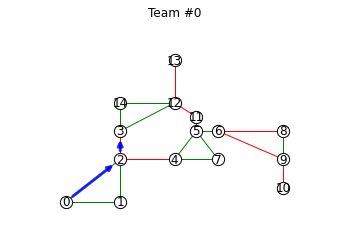

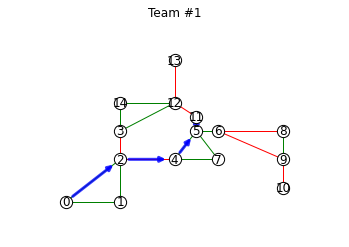

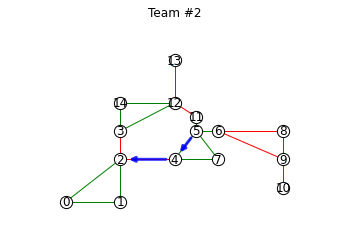

In [46]:
#Organize the values of the decision variables
all_paths = get_f_values(MPC_ARCP, K)
all_routes = organize_teams_routes(all_paths)

#Save the results in a text file
save_RC_variables(end_time - start_time, instance_name, len(all_routes), 
                      objective_function, all_routes, MPC_ARCP)

if display_results == True:
    #Create the images of the network and the teams' routes
    data_visualization(E_no_sink, coordinates, open_road_color, closed_road_color, nodesize, 
                       nodecolor, nodeboundary, instance_name, all_routes, B, team_color)